## Parsing PubMed Abstracts

#### These scripts set you up exploring the biomedical literature on PubMed.  In this notebook, we will build a map of where science happens, based on ZIP codes of the authors' corresponding addresses.

## Environment. 

#### Windows 7 Enterprise, WinPython (3.6.5) and Git for Windows 2.20.1.  This notebook uses a mix of Python and Bash (via %%bash magick) to parse the NCBI XML files.

If you're on Windows like me, launch Jupyter via bash-compliant CLI (e.g. MINGW64 Git Bash).
You won't see the intermediate output from `%%bash` because you need <a href="https://github.com/jupyter/notebook/issues/2023">bash kernel</a> that I just couldn't get to work with WinPython.

<img src="Jupyter-from-GitBash.PNG">

In [1]:
%%bash
ls
#check that %%bash magick is working

fetch-pmdata.sh
Jupyter-from-GitBash.PNG
map
NCBI-Parsing-and-Maps.ipynb
raw


#### Download files with bash
If we are through 2019 and the world is still standing, go to the BASEURL first because the file names and their number will change. The PubMed baseline is updated every December.

In [2]:
%%bash
[ ! -e raw ] && mkdir raw
cd raw
BASEURL="ftp://ftp.ncbi.nlm.nih.gov/pubmed/baseline"
for i in {0001..0002}  #test with this, then switch to next line
#for i in {0001..0972} #you are about to download ~20 GB of files
do
        #echo $i -- run as separate bash script fetch-pmdata.sh to see progress, otherwise just watch the folder 
        file=pubmed19n"$i".xml.gz
        checksum=pubmed19n"$i".xml.gz.md5
        curl -o $file $BASEURL/$file
        curl -o $checksum $BASEURL/$checksum
done

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.5M  100 18.5M    0     0   483k      0  0:00:39  0:00:39 --:--:--  801k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    60  100    60    0     0     27      0  0:00:02  0:00:02 --:--:--    27
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.7M  100 16.7M    0     0  1105k      0  0:00:15  0:00:15 --:--:-- 1480k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    60  100    60    0     0     38      0  0:00:01  0:00:01 --:--:--    38


#### Quick look at the data

In [3]:
%%bash
#first ten lines from an archive
#"zgrep ." = match strings containing ".", a wildcard, in the archived file
zgrep -m 10 . raw/pubmed19n0002.xml.gz

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE PubmedArticleSet SYSTEM "http://dtd.nlm.nih.gov/ncbi/pubmed/out/pubmed_190101.dtd">
<PubmedArticleSet>
  <PubmedArticle>
    <MedlineCitation Status="MEDLINE" Owner="NLM">
      <PMID Version="1">30971</PMID>
      <DateCompleted>
        <Year>1979</Year>
        <Month>01</Month>
        <Day>24</Day>


In [4]:
%%bash
#retrieve PMIDs and publication years
#-n flag for line numbers, -C2 means "two lines around the matching line" 
zgrep -nC2 -m2 "<PMID " raw/pubmed19n0002.xml.gz

4-  <PubmedArticle>
5-    <MedlineCitation Status="MEDLINE" Owner="NLM">
6:      <PMID Version="1">30971</PMID>
7-      <DateCompleted>
8-        <Year>1979</Year>
--
143-  <PubmedArticle>
144-    <MedlineCitation Status="MEDLINE" Owner="NLM">
145:      <PMID Version="1">30970</PMID>
146-      <DateCompleted>
147-        <Year>1979</Year>


In [5]:
%%bash
#some bash magic for you to play around with
#wrote this when I planned to reinvent XML parser in bash
zgrep -nC2 -m5 "<PMID " raw/pubmed19n0002.xml.gz | sed 's/--//g' | perl -00lpe y/\\n/,/ | \
grep "<PubmedArticle>" | awk -F'[<>]' '{print $1" "$7" "$(NF-2)}' | sed -r 's/- {1,5}/ /'

4 30971 1979
143 30970 1979
273 30972 1979
400 30973 1979
515 30974 1979


## On to the real stuff

In [6]:
import datetime
import glob
import gzip
import os
import re
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import savefig
import xml.etree.ElementTree as ET 
import csv

In [7]:
#plot settings
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

#### Explore
Each xml.gz file starts with a tag `<PubmedArticleSet>`, the root of the XML tree. Its branches (children) are the individual articles. Reading in the XML files with built-in Python XML tools parses them into what you can think of as a list of lists.

In [8]:
file = 'raw/pubmed19n0002.xml.gz'
unzipped = gzip.open(file)
tree = ET.parse(unzipped)
root = tree.getroot()
root

<Element 'PubmedArticleSet' at 0x0000000009675DB8>

In [9]:
root.getchildren()[:3]

[<Element 'PubmedArticle' at 0x0000000009675D18>,
 <Element 'PubmedArticle' at 0x00000000096D1638>,
 <Element 'PubmedArticle' at 0x00000000096DD458>]

In [10]:
root.getchildren()[0][:]

[<Element 'MedlineCitation' at 0x0000000009654228>,
 <Element 'PubmedData' at 0x00000000096C8F48>]

In [11]:
root.getchildren()[0][0][:]

[<Element 'PMID' at 0x0000000009654F98>,
 <Element 'DateCompleted' at 0x00000000096A5598>,
 <Element 'DateRevised' at 0x00000000096A54F8>,
 <Element 'Article' at 0x00000000096A5778>,
 <Element 'MedlineJournalInfo' at 0x00000000096C80E8>,
 <Element 'ChemicalList' at 0x00000000096C8278>,
 <Element 'CitationSubset' at 0x00000000096C86D8>,
 <Element 'MeshHeadingList' at 0x00000000096C8728>]

In [12]:
%%bash
zgrep -A8 -m1 "<PubmedArticle>" raw/pubmed19n0002.xml.gz
#Starting to look familiar?

  <PubmedArticle>
    <MedlineCitation Status="MEDLINE" Owner="NLM">
      <PMID Version="1">30971</PMID>
      <DateCompleted>
        <Year>1979</Year>
        <Month>01</Month>
        <Day>24</Day>
      </DateCompleted>
      <DateRevised>


once you get to the tip of the branch, there are no more opening XML tags nested inside:

In [13]:
print(root.getchildren()[0][0][0])
print(root.getchildren()[0][0][0][0])

<Element 'PMID' at 0x0000000009654F98>


IndexError: child index out of range

You are at `<PubmedArticle><MedlineCitation...><PMID Version="1">30971</PMID>`:

In [15]:
print(root.getchildren()[0][0][0].tag)
print(root.getchildren()[0][0][0].text)
print(root.getchildren()[0][0][0].attrib)

PMID
30971
{'Version': '1'}


Once you have an idea of the XML structure, you can starting scripting field extraction functions.

In [16]:
#single field (as written, returns the value of first branch)
def xfield(item, child, integer=True):
    return item.find(child).text
xfield(root, './PubmedArticle/MedlineCitation/PMID')

'30971'

In [17]:
#all fields with given XML structure (returns a list):
def xfield_all(item, child, integer=True):
    return item.findall(child)
data = xfield_all(root, './PubmedArticle/MedlineCitation/PMID')
[x.text for x in data][:5]

['30971', '30970', '30972', '30973', '30974']

## Field Extraction

In [18]:
def xfield(item, child, integer=True):
    field = item.find(child)
    if integer!=True:
        if field is None:
            return ''
        else:
            return field.text
    else:
        if field is None:
            return 0
        else:
            return int(field.text)

#these are some of the fields I worked with
def pmid(fieldname='MedlineCitation/PMID'):
    return xfield(article, fieldname)
def title(fieldname='MedlineCitation/Article/ArticleTitle'):
    return xfield(article, fieldname, integer=False)
def abstract(fieldname='MedlineCitation/Article/Abstract/AbstractText'):
    return xfield(article, fieldname, integer=False)
def affiliations(fieldname='MedlineCitation/Article/AuthorList/Author/AffiliationInfo/Affiliation'):
    try: return ' & '.join(np.unique([x.text for x in article.findall(fieldname)]))
    except: return 'XML_Error'
def pubyear(fieldname='MedlineCitation/Article/Journal/JournalIssue/PubDate/Year', \
            alt_fieldname='PubmedData/History/PubMedPubDate/Year'):
    year = xfield(article, fieldname)
    if year == 0:
        return xfield(article, alt_fieldname)
    else:
        return year
def n_authors(fieldname='MedlineCitation/Article/AuthorList/'):
    return len(article.findall('MedlineCitation/Article/AuthorList/'))
def ISSN(fieldname='MedlineCitation/Article/Journal/ISSN'):
    return xfield(article, fieldname, integer=False)

def pr_progress(text):
    if i in steps:
        print(file + ' ' + text + ' ' + datetime.datetime.now().strftime('%T'))

#### Example:

In [19]:
for article in root.findall('./PubmedArticle')[4:8]:
    print(title())

Treating the outpatient schizophrenic.
[An evaluation of lorazépam (temesta) in out-patient practice (author's transl)].
[Considerations in the drug treatment of parkinsonism (author's transl)].
[Neurohormonal interactions in the regulation of sex behavior].


## Parsing
Let's retrieve **P**MID, **Y**ear of publication, **N**umber of authors, **T**itle, and **A**ffiliations (PYNTA), for articles with non-blank abstract and affiliations.  I'm using "| |" as a field separator, in the event "|" alone shows up in some fields.  In that case, I could use a multi-char separator for downstream parsing.

In [20]:
parent = './PubmedArticle'
files = glob.glob('raw/pubmed19*.gz')

i=0; steps=[1,2,3,5,10,20,50,100,200,400,600,800,900,928]
print('NCBI XML extractor started ' + datetime.datetime.now().strftime('%T'))
for file in files[:2]:
    i+=1
    unzip = gzip.open(file)
    tree = ET.parse(unzip); pr_progress('unzipped')
    root = tree.getroot(); pr_progress('parsed')
    output = open('output.csv', 'a', encoding='utf-8')
    writer = csv.writer(output, delimiter='|')
    
    for article in root.findall(parent):
        row = []
        if (abstract() != '') & (affiliations() != ''):
            row.append(pmid()); row.append(' ')
            row.append(pubyear()); row.append(' ')
            row.append(n_authors()); row.append(' ')
            row.append(title()); row.append(' ')
            row.append(affiliations())
            writer.writerow(row)
    output.close()
    pr_progress('extracted')


NCBI XML extractor started 13:18:51
raw\pubmed19n0001.xml.gz unzipped 13:19:04
raw\pubmed19n0001.xml.gz parsed 13:19:04
raw\pubmed19n0001.xml.gz extracted 13:19:05
raw\pubmed19n0002.xml.gz unzipped 13:19:15
raw\pubmed19n0002.xml.gz parsed 13:19:16
raw\pubmed19n0002.xml.gz extracted 13:19:16


In [21]:
%%bash
#let's take a look...
head output.csv

#### The cell below runs on all 972 volumes of the PubMed baseline.
It took about 5 hrs to execute and produced a 5 GB file with 16,278,757 rows.

In [32]:
parent = './PubmedArticle'
files = glob.glob('raw/pubmed19*.gz')

i=0; steps=[1,2,3,5,10,20,50,100,200,400,600,800,900,928]
print('NCBI XML extractor started ' + datetime.datetime.now().strftime('%T'))
for file in files:
    i+=1
    unzip = gzip.open(file)
    tree = ET.parse(unzip); pr_progress('unzipped')
    root = tree.getroot(); pr_progress('parsed')
    output = open('output.csv', 'a', encoding='utf-8')
    writer = csv.writer(output, delimiter='|')
    
    for article in root.findall(parent):
        row = []
        if (abstract() != '') & (affiliations() != ''):
            row.append(pmid()); row.append(' ')
            row.append(pubyear()); row.append(' ')
            row.append(n_authors()); row.append(' ')
            row.append(title()); row.append(' ')
            row.append(affiliations())
            writer.writerow(row)
    output.close()
    pr_progress('extracted')


NCBI XML extractor started 20:14:49
pubmed19n0001.xml.gz unzipped 20:15:02
pubmed19n0001.xml.gz parsed 20:15:03
pubmed19n0001.xml.gz extracted 20:15:04
pubmed19n0002.xml.gz unzipped 20:15:12
pubmed19n0002.xml.gz parsed 20:15:13
pubmed19n0002.xml.gz extracted 20:15:14
pubmed19n0003.xml.gz unzipped 20:15:26
pubmed19n0003.xml.gz parsed 20:15:27
pubmed19n0003.xml.gz extracted 20:15:27
pubmed19n0005.xml.gz unzipped 20:15:50
pubmed19n0005.xml.gz parsed 20:15:51
pubmed19n0005.xml.gz extracted 20:15:51
pubmed19n0010.xml.gz unzipped 20:16:50
pubmed19n0010.xml.gz parsed 20:16:51
pubmed19n0010.xml.gz extracted 20:16:51
pubmed19n0020.xml.gz unzipped 20:18:47
pubmed19n0020.xml.gz parsed 20:18:47
pubmed19n0020.xml.gz extracted 20:18:48
pubmed19n0050.xml.gz unzipped 20:24:39
pubmed19n0050.xml.gz parsed 20:24:39
pubmed19n0050.xml.gz extracted 20:24:40
pubmed19n0100.xml.gz unzipped 20:35:53
pubmed19n0100.xml.gz parsed 20:35:54
pubmed19n0100.xml.gz extracted 20:35:54
pubmed19n0200.xml.gz unzipped 20:54:

#### Chunking to read in big files
Let's find and plot the average number of authors per year using chunks.  It is not advisable to try to use Pandas to read in a file this size at once.<p>
The output from above was renamed to `PYNTA_all.csv`.  Remember, we're dealing with a 5GB table with 16+ million rows!

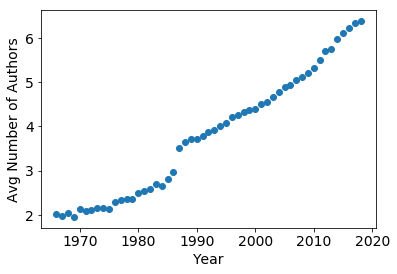

In [33]:
#takes ~4 minutes
rdir = 'C:\\cy\\home\\P2810759\\ncbi\\'; file='PYNTA_all.csv'
pm_chunks = pd.read_csv(file, encoding='utf-8', header=None, \
                 sep='|', usecols=[0,2,4,6,8], \
                 names=['pmid','year','nauth','title','aff'], \
                 chunksize=1000)
pm_pieces = [chunk.groupby('year')['nauth'].agg(['sum','count']) for chunk in pm_chunks]
pm_nauth = pd.concat(pm_pieces).groupby(level=0).sum()
pm_nauth['avg'] = pm_nauth['sum'] / pm_nauth['count']
pm_nauth_recent = pm_nauth.loc[1966:2018,:]

plt.scatter(pm_nauth_recent.index, pm_nauth_recent.avg)
plt.xlabel('Year')
plt.ylabel('Avg Number of Authors')
plt.show()

## Extracting ZIP codes: 
Regexes are super powerful in the right hands.  There's a bajillion conventions for addresses in the scientific literature, and a single regex to cover them would be beyond my Jedi powers.
<p>First let's break up the big PYNTA file by years in bash, and process affiliations fields in Python.
<p>I came up with a rather loose filter <a href="https://regexr.com/47sv9">`\w+,? \w+,?[^\d-][\d]{5}[^\d](?:\d{0,4}.{1,2}\w+)?`</a> to retrieve what might look like a numeric zip code, plus the country or state.  As you can see, it captures both US and non-US addresses.  We're fine with that, because we'll take care of it with the monstrous grep for US entities in the next step.

In [34]:
%%bash
for i in {1966..2018}
do
    grep " |$i| " PYNTA_all.csv | sort -t\| -nk1 > PYNTA_"$i".csv
done

In [35]:
def zipcodes(affiliations):
    try:
        zips = re.findall('\w+,? \w+,?[^\d-][\d]{5}[^\d](?:\d{0,4}.{1,2}\w+)?', affiliations)
        if len(zips)>0: return ' & '.join(zips)
    except: return
    
files = glob.glob('PYNTA_[1-2]*')
for file in files[1:]: 
    pm = pd.read_csv(file, encoding='utf-8', header=None, quoting=csv.QUOTE_NONE, \
                     sep='|', nrows=1e7, usecols=[0,8], \
                     names=['pmid','aff'])
    pm['zips']=pm.aff.apply(lambda x: zipcodes(x))
    pm[~pm.zips.isnull()][['pmid','zips']].to_csv(file.replace('PYNTA','PZ'), sep='|', header=None, index=False)

In [36]:
%%bash
head PZ_2015.csv
wc -l PZ*.csv | tail

21085000|Aprile 2 30031 Dolo
21873301|CataluÃ±a 21, 46021 Valencia & CataluÃ±a 21, 46021 Valencia & Moliner 50, 46100 Burjassot & Moliner 50, 46100 Burjassot
21920876|Spring, MD 20993, USA & Spring, MD 20993, USA & Minneapolis, MN 55455, USA
21971481|Stanford, CA 94305-5795, USA
22045781|Tampa, FL 33612, USA & Tampa, FL 33612, USA
22138688|Seattle, WA 98101, USA & Seattle, WA 98101, USA & Seattle, WA 98195, USA & Seattle, WA 98101, USA & Seattle, WA 98195, USA & Seattle, WA 98101, USA & Seattle, WA 98195, USA & Seattle, WA 98195, USA & Seattle, WA 98101, USA & Seattle, WA 98195, USA & Seattle, WA 98195, USA & Seattle, WA 98195, USA
22143404|Charleston, SC 29425, USA & Boston, MA 02120, USA
22143405|Hill, NC 27599, USA & Indianapolis, IN 46285, USA
22618128|Giustiniani 2, 35128, Padua
22648866|Platz 6, 20146, Hamburg
   179743 PZ_2010.csv
   178075 PZ_2011.csv
   185844 PZ_2012.csv
   180001 PZ_2013.csv
   164931 PZ_2014.csv
   180316 PZ_2015.csv
   192940 PZ_2016.csv
   194146 PZ_2017.

In [37]:
%%bash
for i in {1966..2018}
do
    #here it comes
    cut -d'|' -f2 PZ_"$i".csv | sed 's/&/\n/g' | \
    egrep "Alabama|Alaska|Arizona|Arkansas|California|Colorado|Connecticut|Delaware|Florida|Georgia|Hawaii|Idaho|Illinois|Indiana|Iowa|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New\sHampshire|New\sJersey|New\sMexico|New\sYork|North\sCarolina|North\sDakota|Ohio|Oklahoma|Oregon|Pennsylvania|Rhode\sIsland|South\sCarolina|South\sDakota|Tennessee|Texas|Utah|Vermont|Virginia|Washington|West\sVirginia|Wisconsin|Wyoming|(A[LKSZR])|(C[AOT])|(D[EC])|(F[ML])|(G[AU])|(HI)|(I[DLNA])|(K[SY])|(LA)|(M[EHDAINSOT])|(N[EVHJMYCD])|(MP)|(O[HKR])|(P[WAR])|(RI)|(S[CD])|(T[NX])|(UT)|(V[TIA])|(W[AVIY])|USA?" | \
    grep -oE " [0-9]{5}" | tr -d " " > Z_"$i".txt
done

## Maps 
There are many robust geo packages and solutions, but I chose to draw a map from scratch, using <a href="https://developers.google.com/kml/documentation/us_states.kml">KML polygons from Google</a>. 

In [38]:
file = 'map/USZIP.csv'
uszip = pd.read_csv(file, sep=',', converters={'ZIP':str})
uszip.head()
# Fun fact: first US ZIP code, 00601, is in the town of Adjuntas,
# aka "the Switzerland of Puerto Rico".  No science happened there.

,ZIP,LAT,LNG
0,00601,18.180555,-66.749961
1,00602,18.361945,-67.175597
2,00603,18.455183,-67.119887
3,00606,18.158345,-66.932911
4,00610,18.295366,-67.125135


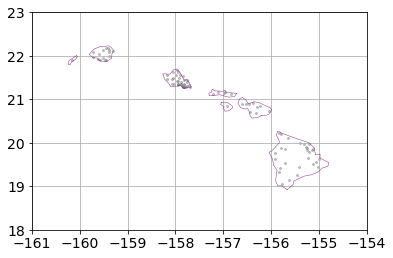

In [39]:
#unzip the .7z archives in map/Polygons folder
def usmap(borders, zips, blw=0.5, size=4, mark='o'):
    rdir = 'map/'; polygons = rdir+'Polygons'
    for p in os.listdir(polygons):
        bor = pd.read_csv(os.path.join(polygons, p), sep=',', header=None)
        bor.columns = ['LNG','LAT']
        ax.plot(bor.LNG, bor.LAT, lw=blw, alpha=borders, c='#770077')
        plt.xlim(-127, -63)
        plt.ylim(23.5, 51.5)
    ax.scatter(uszip.LNG, uszip.LAT, s=size, marker=mark, alpha=zips, c='#777777')
    return
fig, ax = plt.subplots(figsize=(6,4))
usmap(0.8, 0.4)
#Hawaii Inset
plt.xlim(-161, -154); plt.ylim(18, 23)
plt.grid()
plt.show()

#### Data and plotting prep

In [40]:
%%bash
#normalizing by papers per year
echo `wc -l PYNTA_[1-2]*.csv | awk '{print $1}'` | sed 's/ /,/g'

1482,1598,1422,1462,1797,1662,1540,1758,2011,2229,2533,2743,3280,3733,3739,4049,4698,5254,5518,6557,9648,90475,204825,214921,265545,269394,278958,284914,294971,303839,316792,324151,344226,357647,391733,410535,433093,456755,489140,523288,552004,576610,613137,644554,678936,724494,787227,816811,819163,857804,897716,932532,1033671,16258574


In [41]:
#totals papers per year (1966–2018) from the output above
totals_PYNTA = [1482,1598,1422,1462,1797,1662,1540,1758,2011,2229,2533,2743,3280,3733,3739,4049,4698,5254,5518,6557,9648,90475,204825,214921,265545,269394,278958,284914,294971,303839,316792,324151,344226,357647,391733,410535,433093,456755,489140,523288,552004,576610,613137,644554,678936,724494,787227,816811,819163,857804,897716,932532,1033671]
def frac(x):
    return min(100000,1e6*x/total)

#colors
ec=(0.0, 0.1, 0.2, 0.50)
def alphacmap(cmap='plasma', alpha=0.25):
    my_cmap_rgb = plt.get_cmap(cmap)(np.arange(256))
    for i in range(3):
        my_cmap_rgb[:,i] = (1 - alpha) + alpha*my_cmap_rgb[:,i]
    return mpl.colors.ListedColormap(my_cmap_rgb, name='my_cmap')
my_cmap = alphacmap()
c0 = list(my_cmap.colors[0])

#### Plotting
The code will output PNG files.

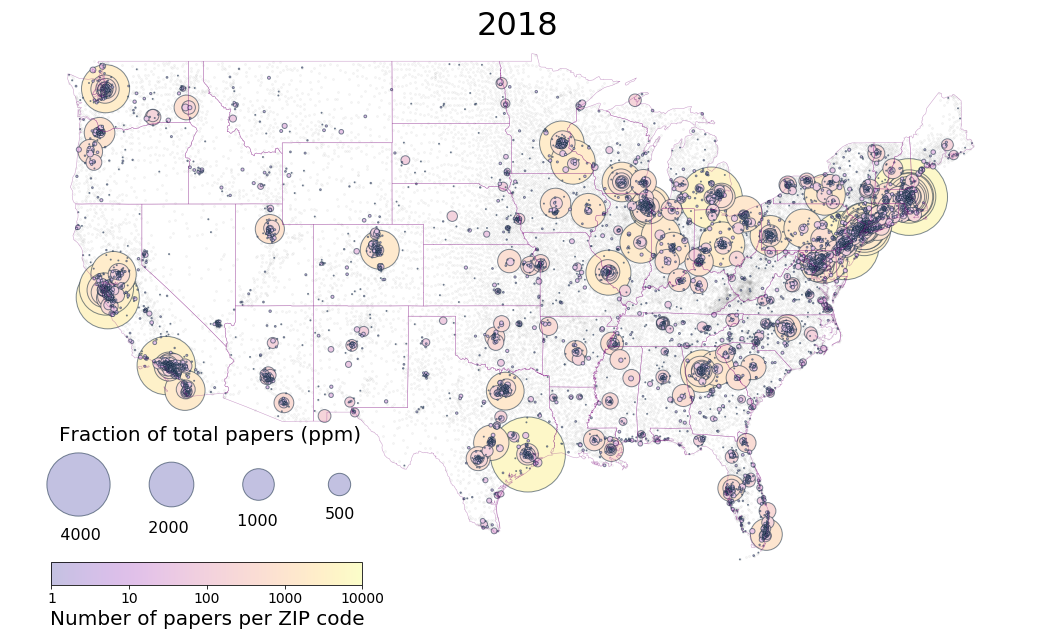

In [42]:
step=1 #increase for debugging
files = glob.glob('Z_*')[0::step]
totals = totals_PYNTA[0::step]
i=0

for file in files:
    plt.close('all')
    zips = pd.read_csv(file, header=None, nrows=1e7, names=['ZIP'], converters={'ZIP':str})

    z = zips.ZIP.value_counts().reset_index()
    z.columns = ['ZIP','n']
    z = z.merge(uszip, on='ZIP')
    z['s'] = np.log10(z.n)
    total = totals[i]; i=i+1
    z['frac']=z.n.apply(lambda x: frac(x))
   
    fig, ax = plt.subplots(figsize=(18.0, 10.5))
    usmap(0.4, 0.06)
    p = ax.scatter(x=z.LNG, y=z.LAT, c=z.s, edgecolors=ec, cmap = my_cmap, s=z.frac, vmin=0, vmax=4)
    plt.xlim(-127, -63)
    plt.ylim(23.5, 51.5)
    plt.axis('off')
                  
    cax = fig.add_axes([0.14, 0.12, 0.24, 0.03]) 
    cbar = fig.colorbar(p, fraction=0.11, pad=0.04, cax=cax, orientation='horizontal')
    
    cbar.set_label('Number of papers per ZIP code', fontsize=20)
    cbar.set_ticks((np.linspace(0,4,5)))
    cbar.set_ticklabels([str(int(x)) for x in 10**cbar.get_ticks()])

    lg = []
    lg.append(mpl.lines.Line2D([], [], lw=0, marker='o', ms=4000**0.5, mfc=c0, mec=ec, label='   '))
    lg.append(mpl.lines.Line2D([], [], lw=0, marker='o', ms=2000**0.5, mfc=c0, mec=ec, label='  '))
    lg.append(mpl.lines.Line2D([], [], lw=0, marker='o', ms=1000**0.5, mfc=c0, mec=ec, label=' ')))
    lg.append(mpl.lines.Line2D([], [], lw=0, marker='o', ms= 500**0.5, mfc=c0, mec=ec))
    leg = ax.legend(loc=(0.02,0.14), ncol=4, handles=lg, fontsize=18, handletextpad=0.2, frameon=False)
    labels = ['   4000','  2000',' 1000','500']
    for x in range(4):
        plt.text(-.02+x*0.3, 2+x*0.3, labels[x], fontsize=16)
    leg.set_title('Fraction of total papers (ppm)\n', prop={'size':'20'})
    plt.suptitle(file[2:6], fontsize=32, y=0.88)
    
    plt.savefig(file[2:6]+'.png', bbox_inches='tight', dpi=72)

#### For fun: Geographical Centers of US Science.

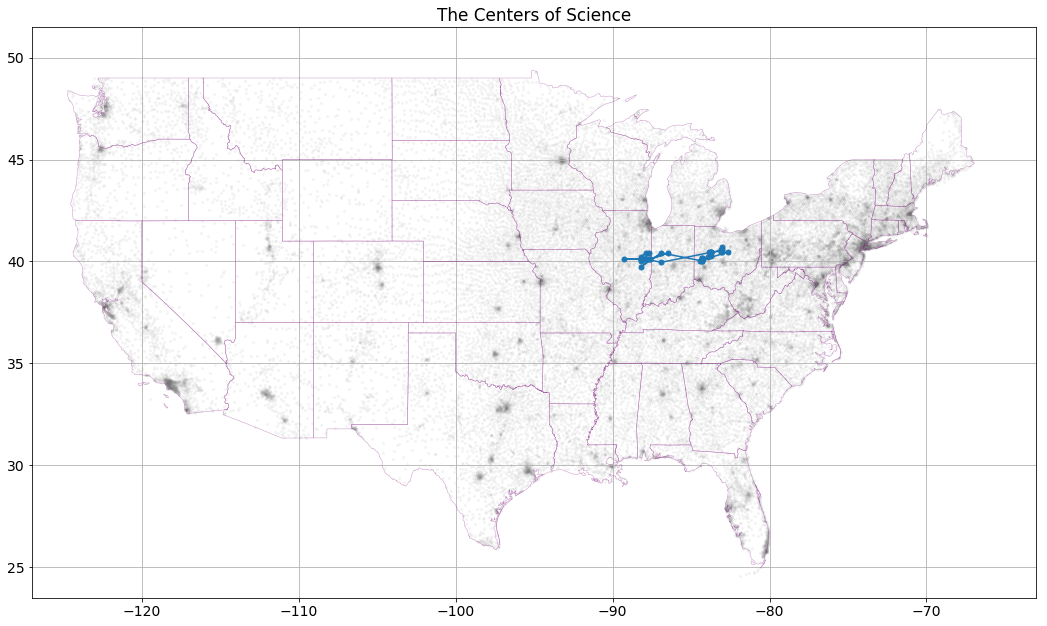

In [43]:
files = glob.glob('Z_*')
d = []
for file in files: 
    zips = pd.read_csv(file, header=None, names=['ZIP'], converters={'ZIP':str})
    z = zips.merge(uszip, on='ZIP')
    d.append([file[2:6], z.LAT.median(), z.LNG.median()])
ctr = pd.DataFrame(data=d, columns=(['year','LAT','LNG']))
fig, ax = plt.subplots(figsize=(18.0, 10.5))
usmap(0.4, 0.06)
plt.plot(ctr.LNG, ctr.LAT, marker='o', ms=5)
plt.title('The Centers of Science')
plt.grid()
plt.show()